In [1]:
!pip install OSMPythonTools


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\KinShish\AppData\Local\Temp\ipykernel_17872\4170849268.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,POINT (131.88558 43.11507),43.275068,42.955068,132.045577,131.725577,265360108,node,27503886,43.115068,131.885577,place,city,16,0.60484,city,Vladivostok,"Vladivostok, Vladivostok City District, Primor..."


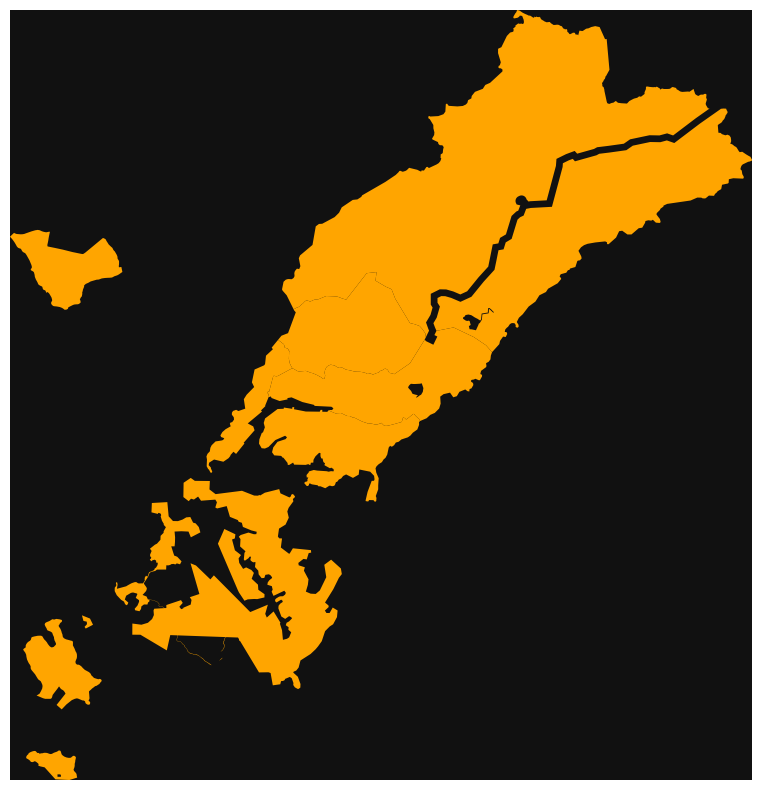

Vladivostok, Vladivostok City District, Primorsky Krai, Far Eastern Federal District, 690091, Russia


In [26]:
import osmnx as ox
import networkx as nx
ox.config(log_console=True, use_cache=True)
place = "владивосток".lower()
gdf_country = ox.features_from_address(place,{"place":["city","town"]})
def find_city(gdf):
    index_city = gdf.index
    #display(gdf)
    for idx,city in enumerate(gdf["name:ru"]):
        if place == city.lower():
            return ox.geocode_to_gdf(index_city[idx][0][0]+str(index_city[idx][1]), by_osmid=True)
gdf_city=find_city(gdf_country)
display(find_city(gdf_country))
tags_city = {'admin_level': ['9']}
areas=[]
try:
    gdf_city_region = ox.features_from_bbox(gdf_city["bbox_north"][0],gdf_city["bbox_south"][0],gdf_city["bbox_east"][0],gdf_city["bbox_west"][0], tags_city)
except:
    gdf_city_region = ox.features_from_bbox(gdf_city["bbox_north"][0],gdf_city["bbox_south"][0],gdf_city["bbox_east"][0],gdf_city["bbox_west"][0], {"place":["city","town"]})

        

fig, ax = ox.plot_footprints(gdf_city_region, figsize=(10, 10))
index_city_region = gdf_city_region.index
print(gdf_city["display_name"][0])


areas=[]
for i in index_city_region:
    if i[0] == "relation":
        #print(gdf_city_region["name"][i])
        gdf_area = ox.geocode_to_gdf("R"+str(i[1]), by_osmid=True)
        areas.append(gdf_area)
        #display(gdf_area.head())

In [27]:
def find_violations(gdf_bad,gdf_educational):
    violations=[]
    gdf_bad = ox.project_gdf(gdf_bad, to_crs =3857)
    gdf_educational = ox.project_gdf(gdf_educational, to_crs =3857)
    for p in gdf_educational["geometry"]:
        distance=p.distance(gdf_bad["geometry"])
        index_distance = distance.index
        for idx,dist in enumerate(distance):
            if dist <= 100:
                violations.append([index_distance[idx],dist])
                #violations.append([index_distance[idx],get_name(index_distance[idx]),dist])
    return violations          
    #gdf_educational['dist']=gdf_bad["geometry"].distance(gdf_educational["geometry"], align=True)
    #display(gdf_educational.head())

def get_name(name):
    gdf_area_local = ox.geocode_to_gdf(name[0][0]+str(name[1]), by_osmid=True)
    return gdf_area_local["display_name"][0]

In [29]:
tags_good = {
    'amenity': "marketplace",
    "building": "riding_hall",
    "highway":"cycleway",
    "leisure":["swimming_pool","stadium","fitness_centre","sports_hall","sports_centre","pitch","park","playground","picnic_table",
               "nature_reserve","track","fitness_centre","fitness_station","stadium","outdoor_seating","golf_course","garden","common",
               "sports_hall","dog_park","resort","horse_riding","fishing","water_park","beach_resort","miniature_golf","ice_rink",
               "bird_hide","swimming_area","bandstand","schoolyard","disc_golf_course","hackerspace","summer_camp","indoor_play","trampoline_park",
               "bathing_place","wildlife_hide","barefoot","paddling_pool","village_swing","sunbathing","foot_bath","soccer_golf","wellness"],
    "shop":["greengrocer","agrarian","farm"]}#, 'place': "suburb"}
tags_bad = {
    'amenity': ["bar","fast_food","biergarten","pub","restaurant"], 
    "shop":["cigarettes","e-cigarette","vape","vape_shop","tobacco","wine",
            "beverages","alcohol","beer","beverages","pizza","fast_food"],
    "cuisine":["pizza","burger","shawarma"]}#, 'place': "suburb"}
tags_educational = {'amenity': ["school","kindergarten","university","college","music_school","language_school","dancing_school","trade_school"]}
result=dict();
#areas
for arae in areas:
    #display(arae.head())
    gdf_good = ox.features_from_bbox(arae["bbox_north"][0],arae["bbox_south"][0],arae["bbox_east"][0],arae["bbox_west"][0], tags_good)
    gdf_bad = ox.features_from_bbox(arae["bbox_north"][0],arae["bbox_south"][0],arae["bbox_east"][0],arae["bbox_west"][0], tags_bad)
    gdf_educational = ox.features_from_bbox(arae["bbox_north"][0],arae["bbox_south"][0],arae["bbox_east"][0],arae["bbox_west"][0], tags_educational)
    violations=find_violations(gdf_bad,gdf_educational)
    #display(violations)
    result[arae["display_name"][0]]=dict();
    #result[arae["display_name"][0]]["gdf_good"]=gdf_good
    #result[arae["display_name"][0]]["gdf_bad"]=gdf_bad
    result[arae["display_name"][0]]["good"]=len(gdf_good)
    result[arae["display_name"][0]]["bad"]=len(gdf_bad)
    result[arae["display_name"][0]]["positive"]=len(gdf_good)-len(gdf_bad)*1.5
    result[arae["display_name"][0]]["violations"]=len(violations)
display(result)    

{'Frunzenskiy rayon, Vladivostok City District, Primorsky Krai, Far Eastern Federal District, Russia': {'good': 2058,
  'bad': 417,
  'positive': 1432.5,
  'violations': 88},
 'Leninsky rayon, Vladivostok City District, Primorsky Krai, Far Eastern Federal District, Russia': {'good': 1453,
  'bad': 274,
  'positive': 1042.0,
  'violations': 74},
 'Первомайский район, Vladivostok City District, Primorsky Krai, Far Eastern Federal District, Russia': {'good': 986,
  'bad': 131,
  'positive': 789.5,
  'violations': 30},
 'Первореченский район, Vladivostok City District, Primorsky Krai, Far Eastern Federal District, Russia': {'good': 1295,
  'bad': 175,
  'positive': 1032.5,
  'violations': 36},
 'Sovietsky rayon, Vladivostok City District, Primorsky Krai, Far Eastern Federal District, Russia': {'good': 1351,
  'bad': 145,
  'positive': 1133.5,
  'violations': 8}}